In [1]:
# if the library changes, during this notebook, realod it automatically
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
bs = 64

### Get data

In [3]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images')]

In [5]:
path_anno = path / 'annotations'
path_img  = path / 'images'
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Javi/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

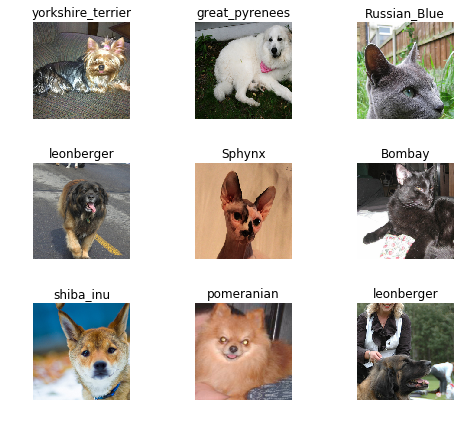

In [6]:
np.random.seed(2)
# pat = r'/([^/]+)_\d+.jpg$' # for linux
pat = r'\\([^\\]+)_\d+.jpg$' #for windows
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

### Training: resnet34

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.model 

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.361371,0.348459,0.098782
2,0.570348,0.271566,0.090663
3,0.356854,0.232536,0.077131
4,0.260267,0.225355,0.074425


In [13]:
learn.save('stage-1')

### Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

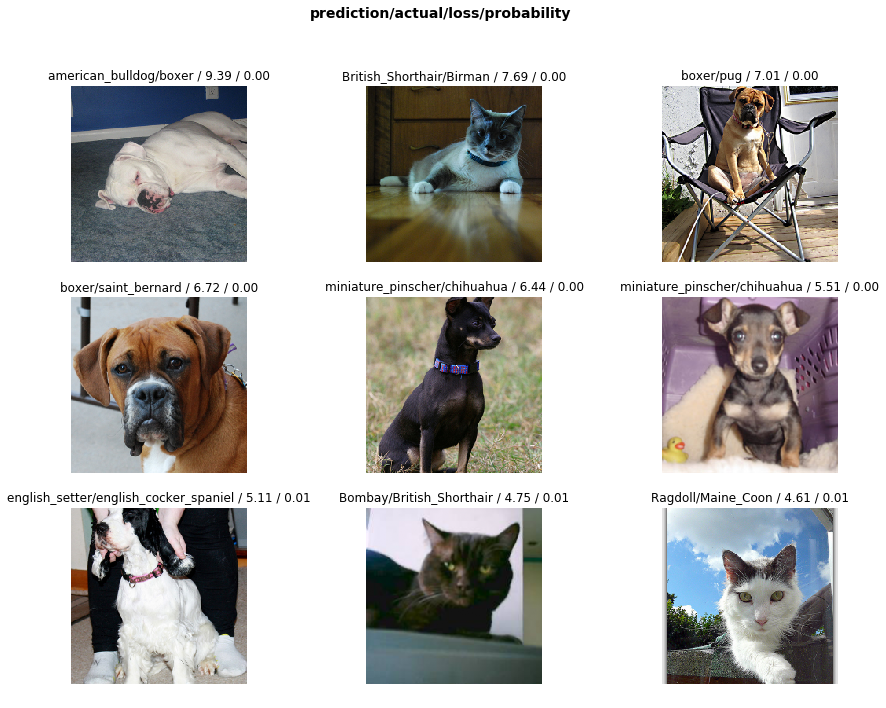

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

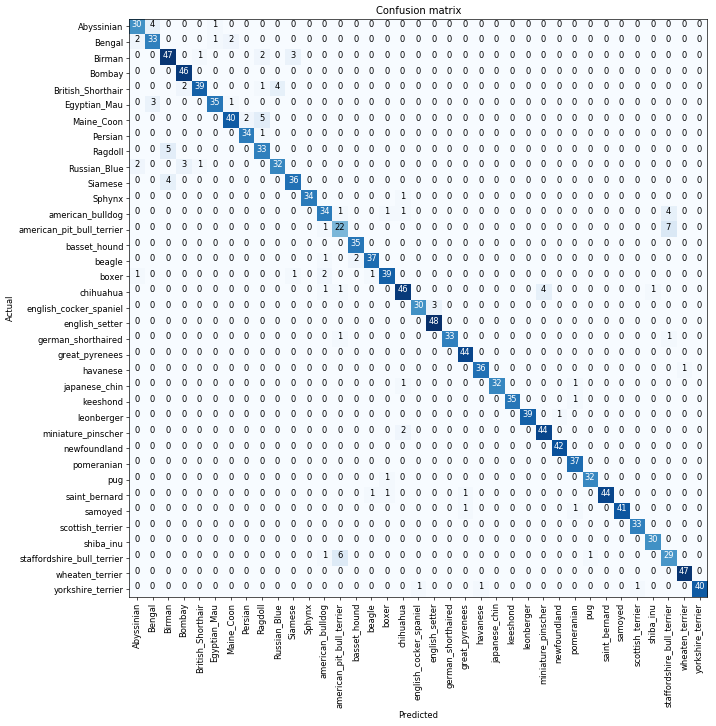

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Maine_Coon', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('Abyssinian', 'Bengal', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Siamese', 'Birman', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Birman', 'Siamese', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('english_cocker_spaniel', 'english_setter', 3)]

### Unfreezing, fine-tuning, and learning rates

In [21]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.543105,0.327183,0.099459


Fijarse que hemos empeorado (0.07->0.09 de error) el modelo al descongelar y entrenar una epoca más.

Esto se debe a que estamos desaprendiedido las primeras capas que fueron aprendidas con imagenet.

Lo que tenemos que hacer es esntranr mas suave (lrs mas bajos)

In [24]:
learn.load('stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


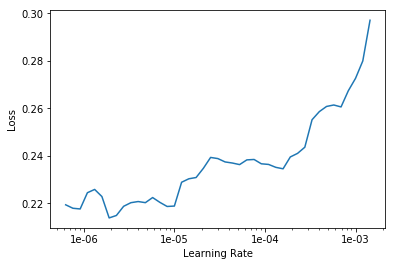

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.231636,0.216099,0.069012
2,0.204393,0.216110,0.069012


### Ahora resnet50

In [8]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


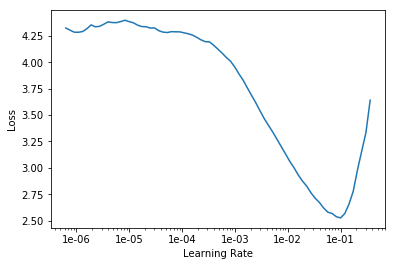

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.749689,0.287368,0.088633
2,0.392690,0.261230,0.087280
3,0.354123,0.223428,0.073748
4,0.281131,0.211095,0.071042
5,0.208059,0.189290,0.055480
6,0.145775,0.173359,0.054804
7,0.115199,0.162403,0.055480
8,0.088032,0.155514,0.054127


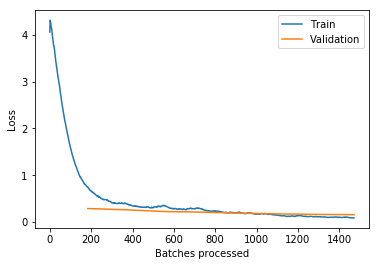

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save('stage-1-50')

In [9]:
learn.load('stage-1-50');

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Abyssinian, Category Abyssinian, Category Abyssinian, Category Abyssinian, Category Abyssinian]...
Path: C:\Users\Javi\.fastai\data\oxford-iiit-pet\images
x: ImageItemList (5912 items)
[Image (3, 400, 600), Image (3, 500, 375), Image (3, 500, 394), Image (3, 313, 450), Image (3, 351, 500)]...
Path: C:\Users\Javi\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList
y: CategoryList (1478 items)
[Category american_pit_bull_terrier, Category keeshond, Category beagle, Category english_setter, Category english_setter]...
Path: C:\Users\Javi\.fastai\data\oxford-iiit-pet\images
x: ImageItemList (1478 items)
[Image (3, 225, 300), Image (3, 331, 500), Image (3, 333, 500), Image (3, 375, 500), Image (3, 500, 375)]...
Path: C:\Users\Javi\.fastai\data\oxford-iiit-pet\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

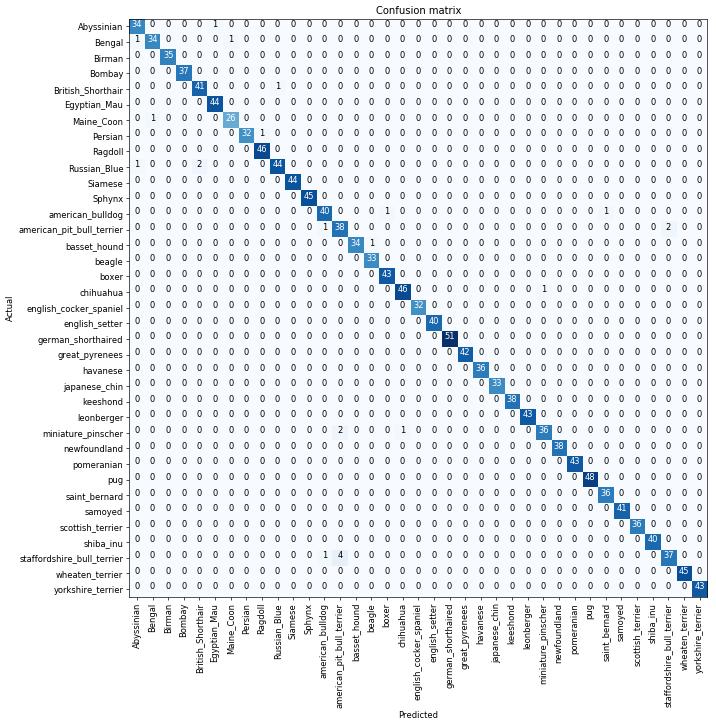

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4)]